# Chess Challenge - GROUP 1
# Dario - Esteban - Miguel - Oriol - Pau

Welcome to the chess challenge of the MQST Qiskit Fall Fest!




The queens puzzle is the problem of placing as many chess queens on an NxN chessboard so that no two queens threaten each other, and is often used as an example for various computation techniques. This problem has not an unique solution, but the complexity of the task of finding one grows exponentially as the number N grows.

#### Cell for installing the necessary packages:

In [1]:
# Uncomment to install the necessary packages
# !pip install numpy
# !pip install scipy
# !pip install matplotlib
# !pip install jupyter
# !pip install qiskit[visualization]==1.2
# # For Local Linux or Mac, you can use the following command:
# # !pip install 'qiskit[visualization]'==1.2
# !pip install qiskit_algorithms
# !pip install qiskit_aer >= 0.14
# !pip install qiskit_ibm_runtime
# !pip install qiskit_ibm_transpiler

### Cell for importing packages

In [104]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import Session
from qiskit.circuit.library import QAOAAnsatz
from qiskit.providers import Backend

# 1- Starting from the basics: before queens there were rooks

To start slowly, we will solve the problem for rooks, for which is much easier to find a solution but has the disadvantage that there are many more solutions. What is the max number of rooks that can fit in a 4x4 chess board? And on a 5x5?

## The first task is to create a classical function that by brute force gives the solutions for the rooks puzzle for NxN chess board.

> Tip: Represent the chess board by an NxN array filled with 0 for the empty squares and by 1 for the squares in which a rook is placed. This representation will also help you during great part of this challenge

If we are working with rooks, none of them can share rows or colummns -> This restricts ourselves to permutations of the diagonal

In [3]:
import itertools


def classical_rooks(N):
    """Returns the solutions of the rooks puzzle for NxN chess board.

    Args:
        N (int): The dimension of the chess board.

    Returns:
        solutions (np.ndarray): The solutions of the rooks puzzle.
    """
    vect = [i for i in range(N)]
    permutations = list(itertools.permutations(vect))

    solutions = []
    for i, sol in enumerate(permutations):
        solution = np.zeros((N, N))
        for j in range(N):
            solution[j, sol[j]] = 1
        solutions.append(solution)

    return np.array(solutions)


def plot_solutions(solutions, N):
    """Plots the solutions of the rooks puzzle for NxN chess board.

    Args:
        N (int): The dimension of the chess board.
    """
    # Your code here

    num_solutions = len(solutions)
    num_cols = int(np.ceil(np.sqrt(num_solutions)))
    num_rows = int(np.ceil(num_solutions / num_cols))

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
    axs = axs.flatten()

    for i, solution in enumerate(solutions):
        axs[i].imshow(solution, cmap="binary")
        axs[i].set_title(f"Solution {i+1}")
        axs[i].axis("off")

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis("off")

    plt.show()

In [4]:
# We check that there are N! solutions
len(classical_rooks(4))

24

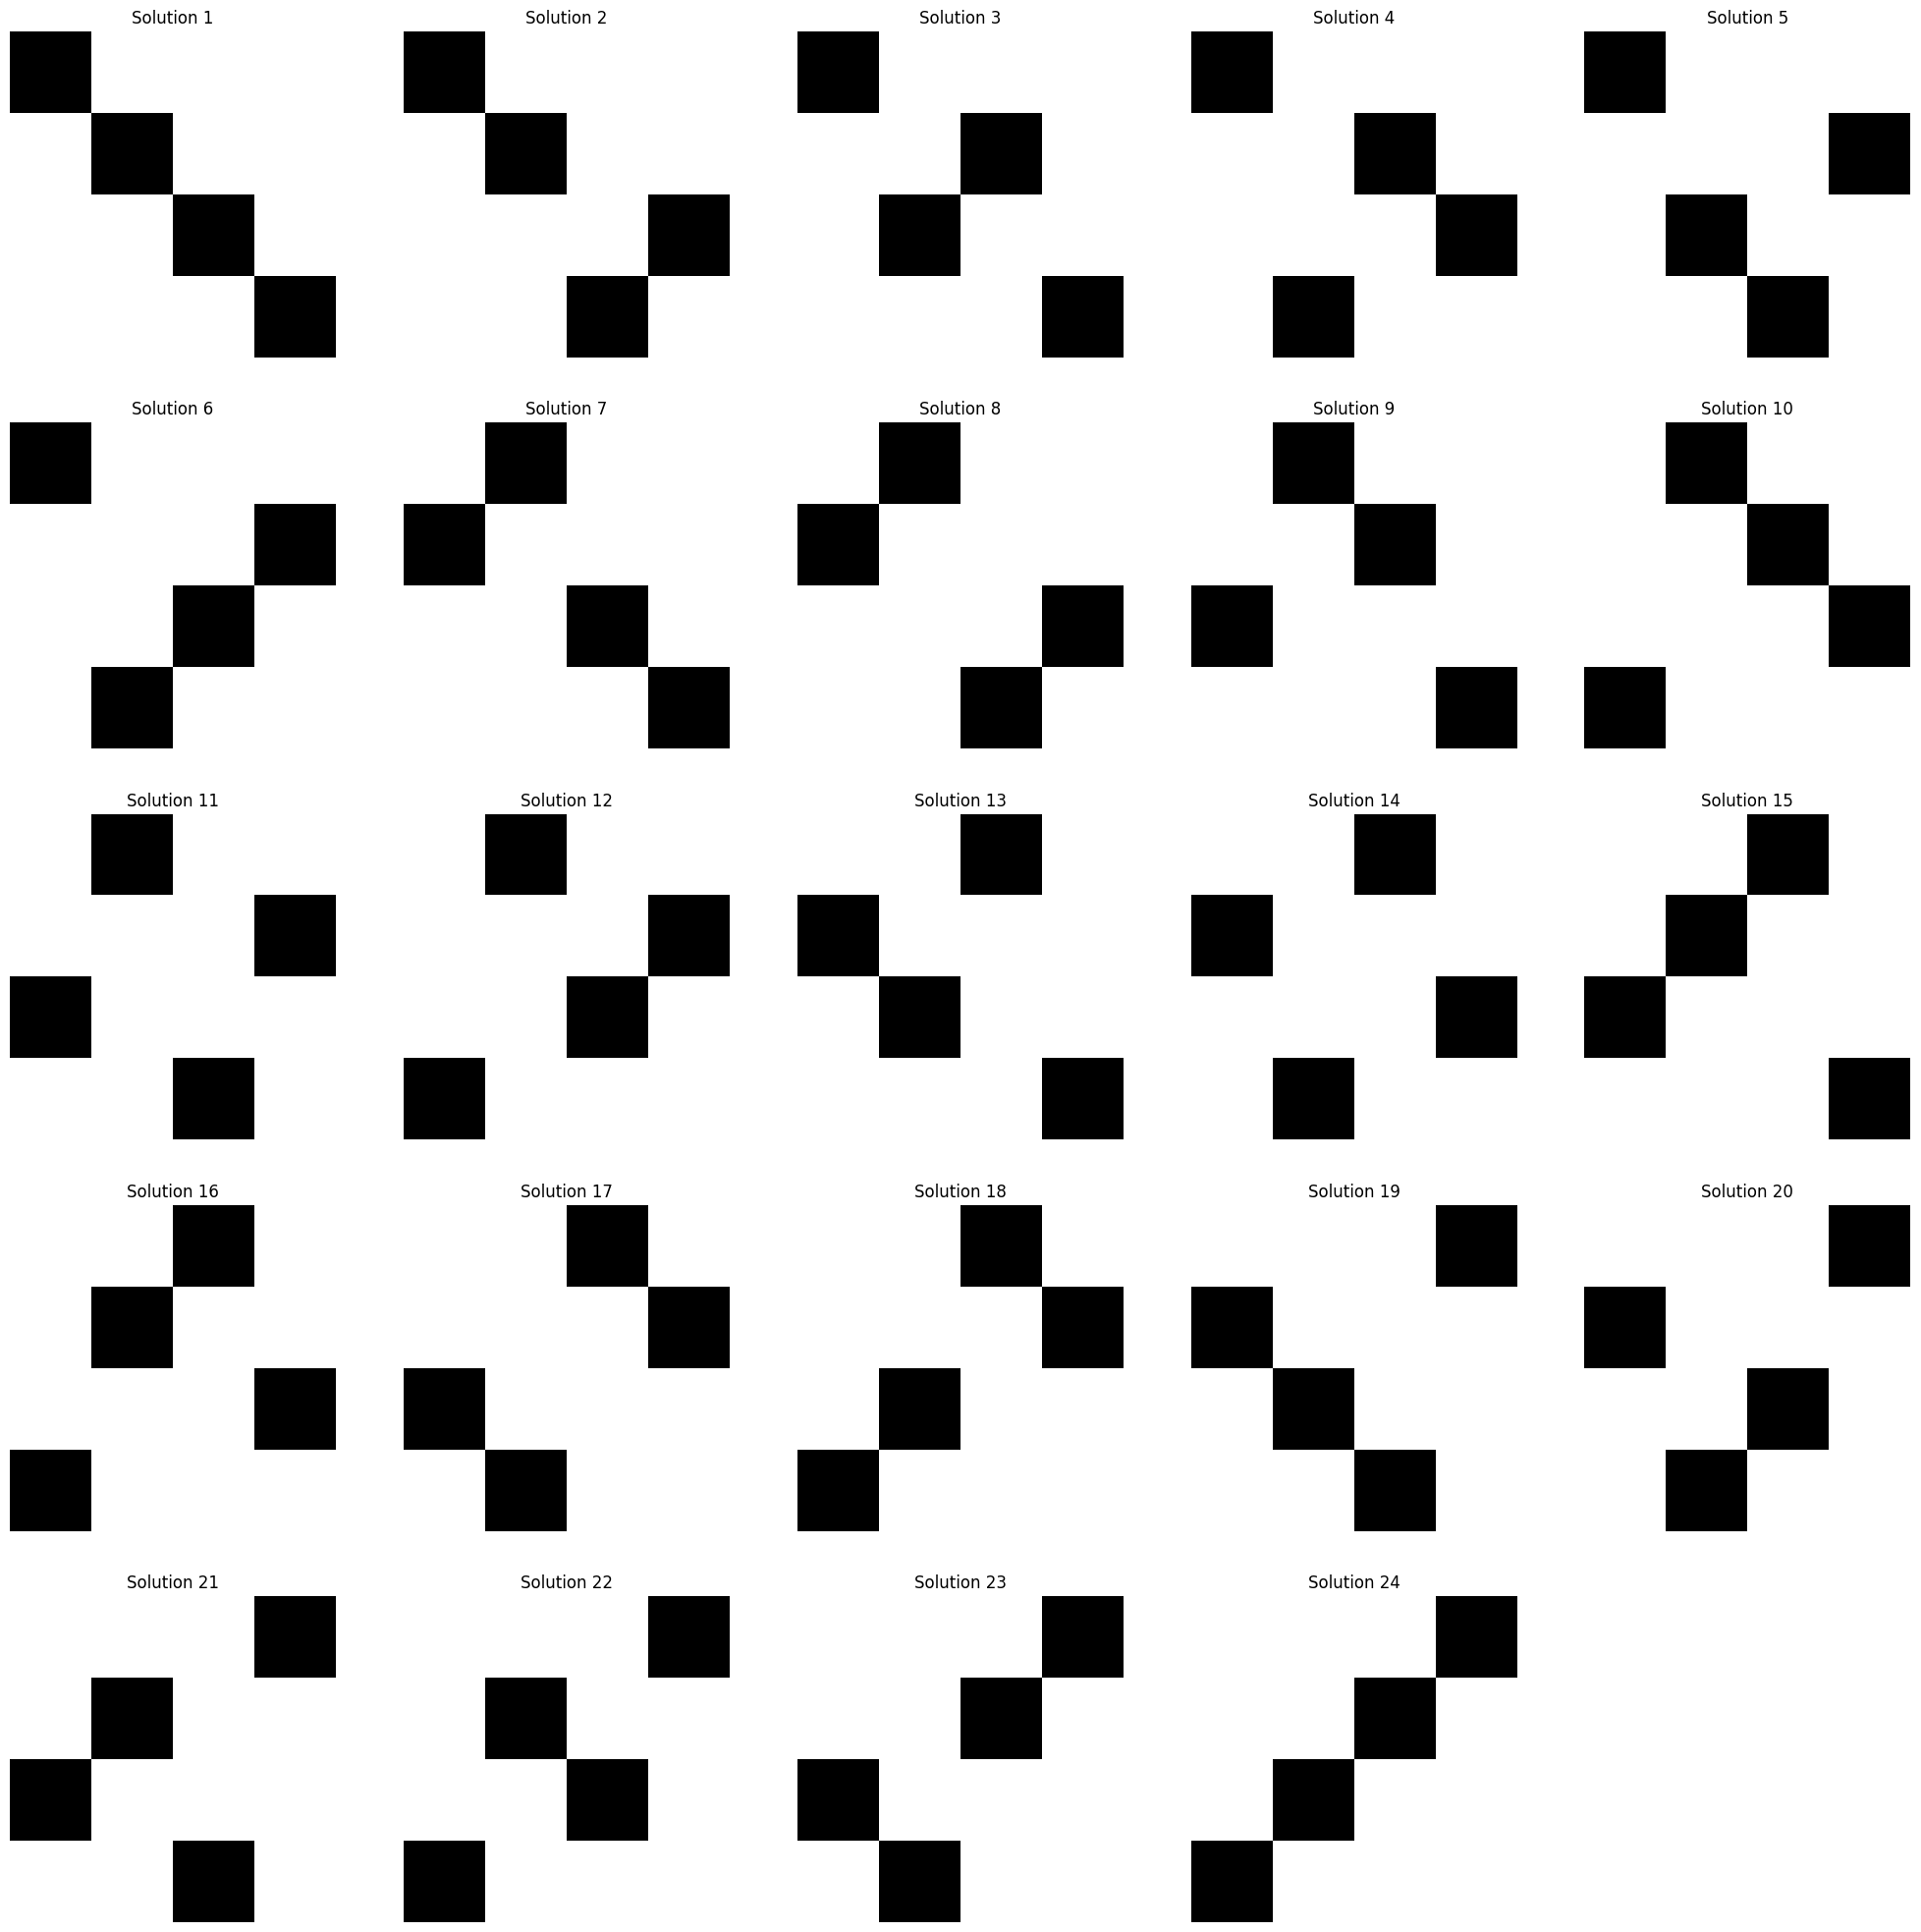

In [5]:
# We plot the solutions:
solutions = classical_rooks(4)
plot_solutions(solutions, 4)

Computing the available solutions by brute force is expensive and untractable when dealing with bigger boards, so we will take advantaje of the hybrid algorithm QAOA to solve this problem in a different way, phrasing the problem as a physics optimization problem, namely finding the state with lowest energy for a given hamiltonian.

The general form of a optimization problem can be written on the form of a hamiltonian:

$$H_C = \sum_{i,j} Q_{ij} X_i X_j + \sum_i b_i X_i$$

where $X_i$ are classical variables can be 1 or 0 and the coefficients $b_i$ and $Q_{ij}$ are problem dependent.

To find a solution using qubits, first we need to map the qubits form a quantum circuit to represent our problem. For that, one suggestion is to use the following mapping:
- Each qubit will represent one square of the chess board, so it will be identified by row and column indices.
- If there is a piece on that square, the spin will be on state $|1>$, and if it is empty the state will be $|0>$

<p style="text-align: center"><img src="https://i.imgur.com/ojkY5to.jpeg"></p>


> Example 3x3 board:
- q0 in state 0 -> 0,0
- q1 in state 0 -> 0,1
- q2 in state 0 -> 0,2
- q3 in state 0 -> 1,0
- q4 in state 0 -> 1,1
- q5 in state 1 -> 1,2
- q6 in state 0 -> 2,0
- q7 in state 0 -> 2,1
- q8 in state 0 -> 2,2

This is just a suitable mapping but it is not unique. There are many more mappings that can be used for this problem, so if you have any other please explain it and use it!!!

For the previous mapping we need $N^2$ qubits to find a solution for a NxN chess board, so a way to improve this mapping could be to reduce the number of qubits needed to map the problem. A new mapping will also change some of the following instructions... be carefull with that!!

To adapt the expression to our problem, we will change the single index $i$ of the classical variables to the actual chess board indices, where latin letters will be rows and greek indices will be columns. Therefore, the classical hamiltonian for our mapping is of the form:

$$H_C = \sum_{k,\alpha ,l,\beta} Q_{k \alpha,l \beta} X_{k\alpha}X_{l\beta} + \sum_{k\alpha} b_{k\alpha} X_{k\alpha}$$

Moreover, we need to define a specific hamiltonian whose groundstate is a solution of the rooks puzzle. For that, we will need two terms:
- One term that lowers the energy with the number of rooks ($|1>$ states)
> Tip: this is a one-body term
- One term that increases the energy if one rook threatens other. This penalization should be bigger than the energy gained by adding one other rook
> Tip: this is a two body interaction term

## Define the weigths $b_{k\alpha}$ and $Q_{k\alpha, l\beta}$ such that the previous cost function has as ground state the solution of the rook's puzzle. Make the cost of threatening 1.5 times the benefit of adding one extra rook (one extra $X$ with 1 value)

> Tip: Adding one more rook DECREASES energy, therefore $b<0$, and having threatened rooks should INCREASE it, therefore $Q>0$. Use $b=-1$ and $Q=1.5$ for those cases where the value is non-zero.

> Tip2: The rooks in chess only move vertical and horizontal, so the only relevant $Q$ coefficients are those for which $k=l$ or $\alpha=\beta$.

In [13]:
def classicalhamiltonian_rook_onebody_coeff(N: int) -> np.ndarray:
    """Returns the NxN matrix of b{k \alpha} weigths.

    Args:
        N (int): The dimension of the chess board.

    Returns:
        bvector (np.array): The NxN matrix of b{k \alpha} weigths.
        hamiltonian (SparsePauliOp): The hamiltonian of the rooks puzzle.

    """
    b_vector = -1 * np.ones((N, N))

    return b_vector


def classical_hamiltonian_rooks_twobody_coeff(N: int) -> np.ndarray:
    """Returns the NxNxNxN array of Q{k \alpha, l \beta} weigths.

    Args:
        N (int): The dimension of the chess board.

    Returns:
        Qmatrix (np.array): The NxNxNxN array of Q{k \alpha, l \beta} weigths.
    """

    Q_matrix = np.zeros((N, N, N, N))

    for i in range(N):
        Q_matrix[i, :, i, :] = 1.5
        Q_matrix[:, i, :, i] = 1.5

    return Q_matrix


def classical_hamiltonian_rooks(N: int, X_string: np.ndarray) -> float:
    """Returns the value of the hamiltonian for a given X_matrix of length NxN.

    Args:
        N (int): The dimension of the chess board.
        Z_matrix (np.array): The NxN matrix of X{k \alpha} values.


    Returns:
        energy (float): The value of the hamiltonian for the given Z_matrix.
    """

    b = classicalhamiltonian_rook_onebody_coeff(N)
    Q = classical_hamiltonian_rooks_twobody_coeff(N)

    one_body_energy = np.einsum("ij, ij", X_string, b)

    two_body_energy = 0.0

    for i in range(N):
        for j in range(N):
            X_temp1 = np.zeros((N, N))
            X_temp2 = np.zeros((N, N))

            if X_string[i][j] == 1:
                X_temp1[i, j] = 1
                X_temp2 = X_string - X_temp1

                two_body_energy += 0.5 * np.einsum("kalb, ka, lb", Q, X_temp1, X_temp2)

    return one_body_energy + two_body_energy


def create_random_chessboard(N):

    board = np.random.randint(0, 2, (N, N))

    return board


def print_chessboard(chessboard):

    plt.imshow(chessboard, cmap="binary")
    plt.show()

In [14]:
Q = classical_hamiltonian_rooks_twobody_coeff(2)
x1 = [[0, 1], [0, 0]]
x1 = [[0, 0], [0, 1]]

np.einsum("kalb, ka, lb", Q, x1, x1)

1.5

### Some examples to test that the output energy is correct

In [15]:
Q = classical_hamiltonian_rooks_twobody_coeff(2)
b = classicalhamiltonian_rook_onebody_coeff(2)

X_string = [[1, 1], [1, 1]]  # Expected +1.5 * 4 - 4 * 1 = 2

print(classical_hamiltonian_rooks(2, X_string))

X_string = [[1, 0], [0, 1]]  # Expected 0 - 2 * 1 = -2

print(classical_hamiltonian_rooks(2, X_string))

2.0
-2.0


### Testing the rest of the functions for a simple example!

[[0 0]
 [0 1]]


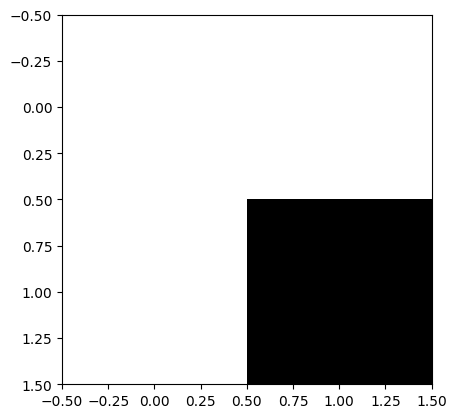

-1.0


In [16]:
N = 2
cb = create_random_chessboard(N)
print(cb)
print_chessboard(cb)

energy = classical_hamiltonian_rooks(N, cb)
print(energy)

As our system is a quantum system where the hamiltonian is an operator, whe should write it in terms of known operators. For that, we will do the change of variable
$$X_{k\alpha} = \frac{1-\hat\sigma^z_{k\alpha}}{2}$$
where $\hat \sigma^z_{k\alpha}$ is the Pauli Z operator acting on the qubit that represents the square of row $k$ and column $\alpha$. Introducing this change of variable on the previous function, you will obtain a quantum operator of the same form with an extra constant term that can be neglected because it only changes the origin of the energy.

> Hint: For this step you might need some pen and paper calculations to find the transformation!

## Write the new hamiltonian and create the associated functions to find the new coefficients

__Write here your hamiltonian__

In [19]:
def z_term(i: int, j: int, N: int) -> str:
    """Helper function to create the Z term for the i,j-th element of the chess board.

    Args:
        i (int): Row index of the chess board.
        j (int): Column index of the chess board.
        N (int): Size of the chess board.

    Returns:
        str: String representation of the Z term.
    """
    index = i * N + j
    z_term = ["I" for _ in range(N * N)]
    z_term[index] = "Z"
    z_term = "".join(z_term)
    return z_term[::-1]


def zz_term(i: int, j: int, k: int, l: int, N: int) -> str:
    """Helper function to create the ZZ term for the i,j-th and k,l-th elements of the chess board.

    Args:
        i (int): Row index of the first element of the chess board.
        j (int): Column index of the first element of the chess board.
        k (int): Row index of the second element of the chess board.
        l (int): Column index of the second element of the chess board.
        N (int): Size of the chess board.

    Returns:
        str: String representation of the ZZ term.
    """
    index1 = i * N + j
    index2 = k * N + l
    z_term = ["I" for _ in range(N * N)]
    z_term[index1] = "Z"
    z_term[index2] = "Z"
    z_term = "".join(z_term)
    return z_term[::-1]


def quantum_hamiltonian_rook_onebody_coeff(N) -> tuple[SparsePauliOp, float]:
    """Returns the Sparse Pauli Op representation of the one body term in the N-rook problem.

    Args:
        N (int): The dimension of the chess board.

    Returns:
        sparse_op (SparsePauliOp): The Sparse Pauli Op representation of the one body term.
        offset (float): The offset of the one body term.
    """
    # Your code here
    b_vector = classicalhamiltonian_rook_onebody_coeff(N)

    op_strings = []
    op_coeff = []
    offset = 0.0

    for i in range(N):
        for j in range(N):
            op_strings.append(z_term(i, j, N))
            op_coeff.append(-0.5 * b_vector[i, j])
            offset += 0.5 * b_vector[i, j]

    sparse_op = SparsePauliOp(op_strings, op_coeff)
    return sparse_op, offset


def quantum_hamiltonian_rooks_twobody_coeff(N) -> tuple[SparsePauliOp, float]:
    """Returns the Sparse Pauli Op representation of the two body term in the N-rook problem.

    Args:
        N (int): The dimension of the chess board.

    Returns:
        sparse_op (SparsePauliOp): The Sparse Pauli Op representation of the two body term.
        offset (float): The offset of the two body term.
    """
    # Your code here
    Q_matrix = classical_hamiltonian_rooks_twobody_coeff(N)

    op_strings = []
    op_coeff = []
    offset = 0.0

    for i in range(N):
        for j in range(N):
            for k in range(N):
                for l in range(N):
                    if i > k or j > l:
                        offset += 0.25 * Q_matrix[i, j, k, l]

                        op_strings.append(z_term(i, j, N))
                        op_coeff.append(-0.25 * Q_matrix[i, j, k, l])

                        op_strings.append(z_term(k, l, N))
                        op_coeff.append(-0.25 * Q_matrix[i, j, k, l])

                        op_strings.append(zz_term(i, j, k, l, N))
                        op_coeff.append(0.25 * Q_matrix[i, j, k, l])

    sparse_op = SparsePauliOp(op_strings, op_coeff)
    return sparse_op, offset

Now, we are able construct the hamiltonian for our problem, using the previous coefficients to create a quantum operator.

## Write a function that creates the hamiltonian of the rooks puzzle as a SparsePauliOp
> Tip: Use the previous functions to obtain the coefficients of the hamiltonian

In [20]:
# In the previous sections we have constructed the one-body and two-body terms of the Hamiltonian in SparsePauliOp
# format directly from the classical Hamiltonian. We can now combine these two terms to obtain the total Hamiltonian.


def cost_hamiltonian_rooks(N):
    """Returns the total hamiltonian of the rooks puzzle in SparsePauliOp format.

    Args:
        N (int): The size of the chess deck.

    Returns:
        hamiltonian (SparsePauliOp): The hamiltonian of the rooks puzzle.
        offset (float): The offset term of the hamiltonian.
    """

    one_term, one_off = quantum_hamiltonian_rook_onebody_coeff(N)
    two_term, two_off = quantum_hamiltonian_rooks_twobody_coeff(N)

    ham = SparsePauliOp.sum([one_term, two_term])
    offset = one_off + two_off

    return ham, offset

In [21]:
cost_hamiltonian_rooks(2)

(SparsePauliOp(['IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZI', 'IIIZ', 'IIZZ', 'IIZI', 'IZII', 'IZZI', 'IZII', 'IIIZ', 'IZIZ', 'IZII', 'IIZI', 'IZZI', 'ZIII', 'IIIZ', 'ZIIZ', 'ZIII', 'IIZI', 'ZIZI', 'ZIII', 'IZII', 'ZZII'],
               coeffs=[ 0.5  +0.j,  0.5  +0.j,  0.5  +0.j,  0.5  +0.j, -0.375+0.j, -0.375+0.j,
   0.375+0.j, -0.   +0.j, -0.   +0.j,  0.   +0.j, -0.375+0.j, -0.375+0.j,
   0.375+0.j, -0.   +0.j, -0.   +0.j,  0.   +0.j, -0.   +0.j, -0.   +0.j,
   0.   +0.j, -0.375+0.j, -0.375+0.j,  0.375+0.j, -0.375+0.j, -0.375+0.j,
   0.375+0.j]),
 -0.5)

# 1.1 Finding solutions for the rook puzzle

Now that we have constructed the hamiltonian that encodes the solution of the problem, we just need to find the groundstate of it.
For that we will use the QAOA algorithm, where the circuit is optimized to find a groundstate of the cost function.

In the QAOA workflow, the optimal QAOA parameters are found in an iterative optimization loop, which runs a series of circuit evaluations and uses a classical optimizer to find the optimal parameters.
Check [QAOAAnsatz](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.QAOAAnsatz), and using scipy [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function run the QAOA algorithm to find the solution of the rooks puzzle, using only two layers.

> Note: There is an example at [IBM web](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm) but it contains the way to run the algorithm on real hardware which up to now it is not the goal. Check it to get inspiration but run this optimization locally using AerSimulator or any other simulated backend.

> Note 2: The solution might not be unique


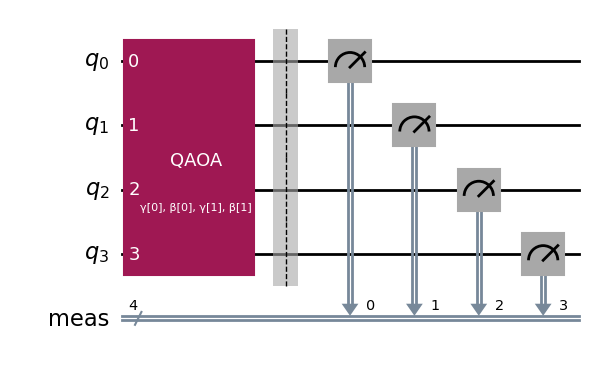

In [22]:
cost_hamiltonian = cost_hamiltonian_rooks(2)[0]

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw("mpl")

In [45]:
from scipy.optimize import minimize
from qiskit.circuit.library import EfficientSU2

objective_func_vals = []


def cost_function_estimator(
    params: np.ndarray, hamiltonian: SparsePauliOp, estimator: Estimator, backend: Backend
) -> float:
    """Cost function estimator to optimize the QAOA parameters.

    Args:
        params (np.ndarray): The current parameters of the QAOA ansatz.
        hamiltonian (SparsePauliOp): The cost hamiltonian of the rooks puzzle.
        estimator (Estimator): the estimator object to be used.
        backend (Backend): The qiskit backend to run the circuits.

    Returns:
        float: The expected value of the cost hamiltonian given the qaoa circuit with the current parameters.
    """

    n_layers = len(params) // 2

    circuit = QAOAAnsatz(cost_operator=hamiltonian, reps=n_layers)
    circuit.measure_all()

    pass_manager = generate_preset_pass_manager(2, backend)
    isa_circuit = pass_manager.run(circuit)

    pub = (isa_circuit, hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)

    return cost


def QAOA_optimizer(
    n_layers: int, hamiltonian: SparsePauliOp, offset: float, backend: Backend, method: str = "COBYLA"
) -> dict:
    """Optimizes the a QAOA ansatz given a hamiltonian.

    Args:
        hamiltonian (SparsePauliOp): The cost Hamiltonina to which we want to find the ground state.
        offset (float): The offset energy of the hamiltonian.
        backend (Backend): The backend to run the circuits.
        method (str): The optimization method to use. Default is "COBYLA".

    Returns:
        dict: The optimization result of the QAOA ansatz.
    """
    init_params = np.random.rand(2 * n_layers)

    with Session(backend=backend) as session:
        estimator = Estimator(mode=session)

        result = minimize(
            cost_function_estimator,
            init_params,
            args=(hamiltonian, estimator, backend),
            method=method,
        )

    global objective_func_vals
    objective_func_vals = [objective_func_vals[i] + offset for i in range(len(objective_func_vals))]
    return result

In [46]:
simulator = AerSimulator()
ham, offset = cost_hamiltonian_rooks(2)

optimization_result = QAOA_optimizer(3, ham, offset, simulator)

In [47]:
optimization_result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.1568603515625
       x: [-3.782e-01  9.996e-01  2.044e+00  6.881e-01  2.683e+00
            5.960e-01]
    nfev: 79
   maxcv: 0.0

In [72]:
def QAOA_sample_circuit(params: np.ndarray, cost_hamiltonian: SparsePauliOp, backend: Backend) -> dict[str, int]:
    """Helper function to sample the QAOA circuit given the final optimization parameters.

    Args:
        params (np.ndarray): The parameters of the QAOA ansatz.
        cost_hamiltonian (SparsePauliOp): The cost hamiltonian.
        backend (Backend): The backend used to run the circuits.

    Returns:
        dict[str, int]: The frequency of the measurements of the QAOA circuit.
    """
    sampler = Sampler(mode=backend)
    n_layers = len(params) // 2

    circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=n_layers)
    circuit.measure_all()
    circuit.assign_parameters(params, inplace=True)

    pass_manager = generate_preset_pass_manager(2, backend)
    isa_circuit = pass_manager.run(circuit)
    result = sampler.run(
        [(isa_circuit,)],
        shots=1000,
    ).result()

    return result[0].data.meas.get_counts()


def freq_plot_solution(counts: dict[str, int], N: int) -> None:
    """Plots the frequency of the measurements of the QAOA circuit.

    Args:
        counts (dict[str, int]): The frequency of the measurements of the QAOA circuit.
        N (int): The size of the chess board.
    """

    max_counts_sol = max(counts, key=counts.get)

    solution = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            index = i * N + j
            if max_counts_sol[index] == "1":
                solution[i, j] = 1

    plt.imshow(solution, cmap="binary")
    plt.show()

In [73]:
ham = cost_hamiltonian_rooks(2)[0]

QAOA_sample_circuit(optimization_result.x, ham, simulator)

# We get the expected results for the solutions of the rooks puzzle:
# 1001:
# x 0
# 0 x
# -------------
# 0110:
# 0 x
# x 0

{'1100': 37,
 '1000': 73,
 '0000': 110,
 '0110': 75,
 '0001': 62,
 '0100': 79,
 '0010': 75,
 '1001': 92,
 '0101': 36,
 '1111': 204,
 '1110': 27,
 '1101': 16,
 '1011': 21,
 '0011': 37,
 '0111': 19,
 '1010': 37}

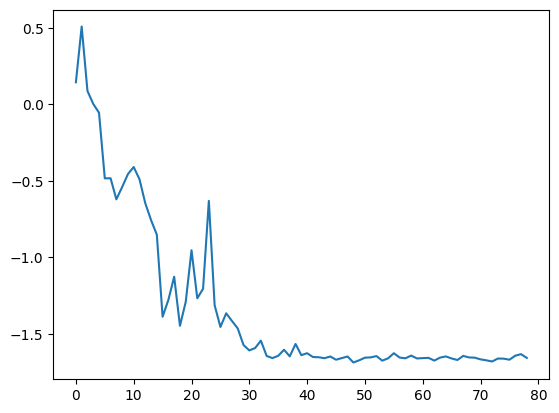

In [50]:
# We can also plot the energy evolution during the optimization process:
plt.plot(objective_func_vals)

## Run the QAOA algorithm for 3x3 and 4x4 boards and discuss the solutions obtained.
## Compare the solutions with the ones obtained by brute force.

# 1.2 Finding a specific solution for the rook puzzle

As you might have seen before, the solution obtained using the previous hamiltonian is usually a superposition of all possible configurations of rooks on the board. To obtain a single solution, we must break the degeneracy of the solution by unbalancing the positions in which the rooks appear.

One of the simplest ways to do this is "tilting" the chess board, i.e., favoring the positioning of the rooks on one side of the board. To do this, one can add a small bias on the single-body terms of the form:

- $b_{00}$ <- $b_{00}$
- $b_{01}$ <- $b_{01}$ + $\delta$
- $b_{02}$ <- $b_{02}$ + $\sqrt{2}\delta$
- ...
- $b_{NN}$ <- $b_{NN}$ + $N\delta$

where $\delta$ should be small compared with the value of $b$ and $Q$, but not infinitely small. You might optimize this by comparing some solutions for different values of $\delta$, or maybe use your creativity to break the degeneracy using different weights and method.

## Introduce the modification on the one-body terms and run again all the steps of the algorithm to find a solution of the rook puzzle. What is the accuracy for the algorithm to find the solution?

> Extra: Can you implement this bias also for the brute force search?

In [51]:
def classical_hamiltonian_rook_onebody_coeff_tilted(N: int, max_tilt: float) -> np.ndarray:
    """Returns the NxN matrix of b_{k \alpha} weigths for a tilted chess board.

    Args:
        N (int): The dimension of the chess board.

    Returns:
        b_vector (np.array): The NxN matrix of b_{k \alpha} weigths.
        hamiltonian (SparsePauliOp): The hamiltonian of the rooks puzzle.
    """
    # Your code here

    b_vector = -1 * np.ones((N, N))

    max_tilt = 0.1
    incr = max_tilt / (N**2)

    for i in range(N):
        for j in range(N):
            b_vector[i, j] += (i * N + j) * incr

    return b_vector


def shifted_quantum_hamiltonian_rook_onebody_coeff(N, max_tilt: float) -> tuple[SparsePauliOp, float]:
    """Returns the Sparse Pauli Op representation of the one body term in the N-rook problem.

    Args:
        N (int): The dimension of the chess board.
        max_tilt (float): The maximum tilt of the chess board.

    Returns:
        sparse_op (SparsePauliOp): The Sparse Pauli Op representation of the one body term.
        offset (float): The offset of the one body term.
    """
    # Your code here
    b_vector = classical_hamiltonian_rook_onebody_coeff_tilted(N, max_tilt)

    op_strings = []
    op_coeff = []
    offset = 0.0

    for i in range(N):
        for j in range(N):
            op_strings.append(z_term(i, j, N))
            op_coeff.append(-0.5 * b_vector[i, j])
            offset += 0.5 * b_vector[i, j]

    sparse_op = SparsePauliOp(op_strings, op_coeff)
    return sparse_op, offset


def shifted_cost_hamiltonian_rooks(N: int, max_tilt: float) -> tuple[SparsePauliOp, float]:
    """Returns the total hamiltonian of the rooks puzzle in SparsePauliOp format on a shifted board.

    Args:
        N (int): The size of the chess board.

    Returns:
        hamiltonian (SparsePauliOp): The hamiltonian of the rooks puzzle.
        offset (float): The offset term of the hamiltonian.
    """

    one_term, one_off = shifted_quantum_hamiltonian_rook_onebody_coeff(N, max_tilt)
    two_term, two_off = quantum_hamiltonian_rooks_twobody_coeff(N)

    ham = SparsePauliOp.sum([one_term, two_term])
    offset = one_off + two_off

    return ham, offset

In [52]:
simulator = AerSimulator()
ham, offset = shifted_cost_hamiltonian_rooks(2, 0.1)

optimization_result = QAOA_optimizer(3, ham, offset, simulator)

In [53]:
QAOA_sample_circuit(optimization_result.x, ham, simulator)

# In this case we do not have a clear solution as both configurations are symmetric under this shift. Won't be the case
# for larger boards.

{'0110': 403,
 '0100': 35,
 '1010': 6,
 '1001': 418,
 '0000': 3,
 '1000': 33,
 '0001': 34,
 '0010': 41,
 '1111': 12,
 '1101': 1,
 '1110': 1,
 '0011': 4,
 '1100': 5,
 '1011': 2,
 '0101': 1,
 '0111': 1}

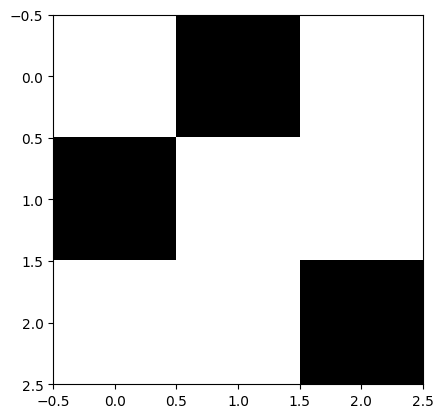

In [54]:
simulator = AerSimulator()
ham, offset = shifted_cost_hamiltonian_rooks(3, 0.1)

optimization_result = QAOA_optimizer(3, ham, offset, simulator)

freq = QAOA_sample_circuit(optimization_result.x, ham, simulator)

freq_plot_solution(freq, 3)

# 1.3 Improving the optimization

Now that everything is working properly, let's improve the QAOA protocol. Test the convergence of the solution and the parameters by changing different parameters of the algorithm.

Can you find a classical optimization algorithm that converges faster than the one by default on scipy.optimize? Does it change the result on the QAOA algorithm?

Does the convergence or the final solution improve using a different mixing operator?

How does the convergence and final solution change if we increase the number of layers from 2 to 3? How does the computation time change?

In [56]:
# We have tested both the default scipy minimizer and the COBYLA method. The use of cobyla is due to it being
# the default in IBM's example on how to run the QAOA algorithm. We can see that the results are much better with it,
# as the default minimizer does not converge to the optimal solution.

simulator = AerSimulator()
ham, offset = cost_hamiltonian_rooks(2)

optimization_result = QAOA_optimizer(3, ham, offset, simulator, method=None)

optimization_result

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.5191650390625
        x: [ 4.570e-02  4.123e-01  7.924e-01  6.666e-01  3.536e-01
             9.303e-01]
      nit: 2
      jac: [-7.045e+05  1.966e+05 -8.192e+04 -2.294e+05  2.564e+06
             6.226e+05]
 hess_inv: [[ 7.802e-01 -3.595e-01 ... -1.747e-01 -1.113e-01]
            [-3.595e-01  1.442e+00 ...  1.076e+00  6.335e-01]
            ...
            [-1.747e-01  1.076e+00 ...  1.104e+00  1.092e+00]
            [-1.113e-01  6.335e-01 ...  1.092e+00  1.583e+00]]
     nfev: 166
     njev: 22

# 2- Diagonal movement

As the queens can also move in diagonal, we will carefully analyze that movement playing the same game with bishops. (Be careful, this time for a board of NxN squares there are more than N possible bishops!!!!!!!!!!)

Repeat all previous steps with the bishops puzzle, to understand how can the diagonal movement be introduced in the hamiltonian. Fill all the following steps and comment everything you do to find the solution for 3x3 and 4x4 boards:

In [58]:
# Create the brute force function to find the solutions of the bishop puzzle

from itertools import product


def generate_valid_matrices(N: int) -> list[np.ndarray]:
    """Generates all valid matrices for the bishop puzzle on an N x N chessboard.
    A valid matrix is defined as a matrix where:
    - Each row and each column contains exactly one bishop.
    - No two bishops can attack each other, i.e., no two bishops share the same primary or secondary diagonal.
    - The total number of bishops is 2 * N - 2.

    Arguments:
        N (int): The size of the chessboard (N x N).

    Returns:
        List[np.ndarray]: A list of valid N x N matrices representing the bishop placements.
    """

    def has_no_diagonal_conflicts(matrix: np.ndarray) -> bool:
        """Helper function to check if a matrix has no diagonal conflicts.

        Args:
            matrix (np.ndarray): The matrix to be checked

        Returns:
            bool: Whether the matrix has no diagonal conflicts.
        """
        primary_diagonal = set()
        secondary_diagonal = set()

        for i in range(N):
            for j in range(N):
                if matrix[i, j] == 1:
                    if (i - j) in primary_diagonal or (i + j) in secondary_diagonal:
                        return False
                    primary_diagonal.add(i - j)
                    secondary_diagonal.add(i + j)

        return True

    can_basis = []
    for i in range(N):
        vect = np.zeros(N)
        vect[i] = 1
        can_basis.append(vect)

    combinations = []
    for i in range(2**N):
        binary = format(i, f"0{N}b")
        v = np.zeros(N)
        for j in range(N):
            v += int(binary[j]) * can_basis[j]
        combinations.append(v)

    valid_matrices = []
    for rows in product(combinations, repeat=N):
        matrix = np.array(rows)
        if has_no_diagonal_conflicts(matrix) and np.sum(matrix) == 2 * N - 2:
            valid_matrices.append(matrix)

    return valid_matrices

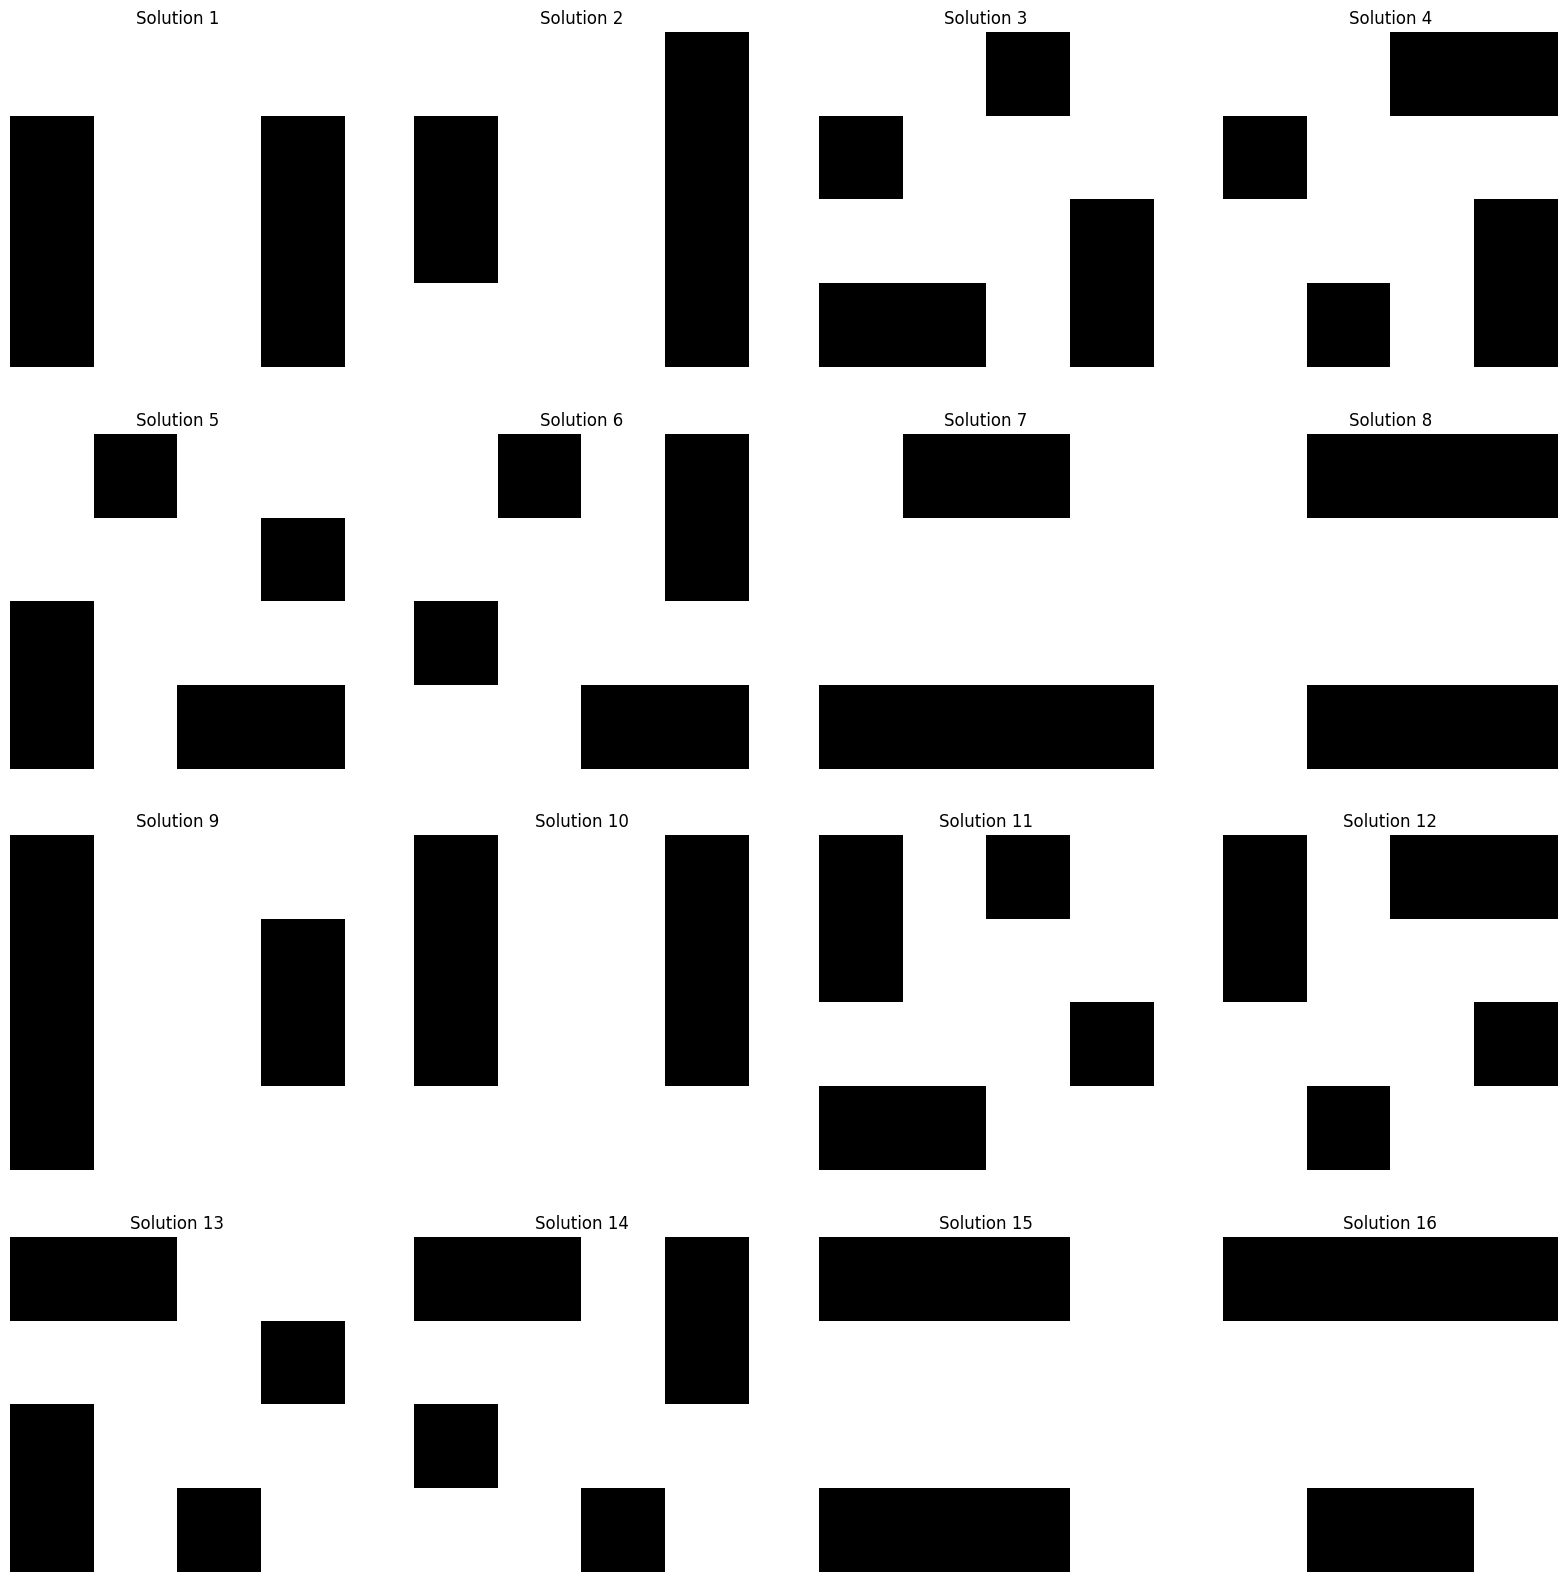

In [60]:
# Example usecase for N = 4
N = 4
valid_matrices = generate_valid_matrices(N)
plot_solutions(valid_matrices, N)

In [63]:
# Create the coefficients of the classical cost function for the bishop puzzle


def classicalhamiltonian_bishop_onebody_coeff(N: int) -> np.ndarray:
    """Return the one-body coefficients for the bishop puzzle.

    Args:
        N (int): The size of the chess board.

    Returns:
        np.ndarray: The one-body coefficients for the bishop puzzle.
    """
    b_vector = -1 * np.ones((N, N))

    return b_vector


def classicalhamiltonian_bishop_twobody_coeff(N: int) -> np.ndarray:
    """Return the two-body coefficients for the bishop puzzle.

    Args:
        N (int): The size of the chess board.

    Returns:
        np.ndarray: The two-body coefficients for the bishop puzzle.
    """
    Q_matrix = np.zeros((N, N, N, N))
    for k in range(N):
        for alpha in range(N):
            for l in range(N):
                for beta in range(N):
                    if abs(k - l) == abs(alpha - beta) and (k, alpha) != (l, beta):
                        Q_matrix[k, alpha, l, beta] = 1.5
    return Q_matrix


def classical_hamiltonian_bishops(N: int, X_string: np.ndarray) -> float:
    """Return the value of the hamiltonian for a given X_matrix of size NxN indicating the position of the bishops.

    Args:
        N (int): The size of the chess board.
        X_string (np.ndarray): The NxN matrix indicating the position of the bishops.

    Returns:
        float: The energy of the hamiltonian for the given X_matrix.
    """
    b = classicalhamiltonian_bishop_onebody_coeff(N)
    Q = classicalhamiltonian_bishop_twobody_coeff(N)

    onebody_term = np.einsum("ij, ij", X_string, b)

    twobody_term = 0
    counted_pairs = set()
    for k in range(N):
        for alpha in range(N):
            for l in range(N):
                for beta in range(N):
                    if (k, alpha) != (l, beta) and (k, alpha) not in counted_pairs and (l, beta) not in counted_pairs:
                        if abs(k - l) == abs(alpha - beta):
                            twobody_term += Q[k, alpha, l, beta] * X_string[k, alpha] * X_string[l, beta]
                            counted_pairs.add(((l, beta)))

    energy = onebody_term + twobody_term
    return energy


def create_random_chessboard(N):
    board = np.random.randint(0, 2, (N, N))
    return board


def print_chessboard(chessboard):
    plt.imshow(chessboard, cmap="binary")
    plt.show()

### Testing the functions for a simple example!

[[0 0]
 [1 1]]


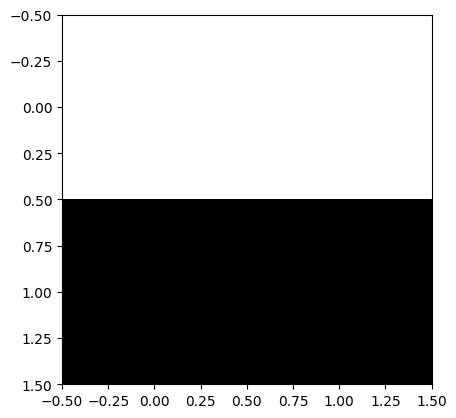

-2.0


In [64]:
N = 2
cb = create_random_chessboard(N)
print(cb)
print_chessboard(cb)

energy = classical_hamiltonian_bishops(N, cb)
print(energy)

In [81]:
# Create the hamiltonian operator for the bishop puzzle, add the tilting

# For the tilted chess, we can reuse the one-body coeffs of the rooks puzzle


def quantum_hamiltonian_bishops_twobody_coeff(N) -> tuple[SparsePauliOp, float]:
    """Returns the Sparse Pauli Op representation of the two body term in the N-rook problem.

    Args:
        N (int): The dimension of the chess board.

    Returns:
        sparse_op (SparsePauliOp): The Sparse Pauli Op representation of the two body term.
        offset (float): The offset of the two body term.
    """
    # Your code here
    Q_matrix = classicalhamiltonian_bishop_twobody_coeff(N)

    op_strings = []
    op_coeff = []
    offset = 0.0

    for i in range(N):
        for j in range(N):
            for k in range(N):
                for l in range(N):
                    if i > k or j > l:
                        offset += 0.25 * Q_matrix[i, j, k, l]

                        op_strings.append(z_term(i, j, N))
                        op_coeff.append(-0.25 * Q_matrix[i, j, k, l])

                        op_strings.append(z_term(k, l, N))
                        op_coeff.append(-0.25 * Q_matrix[i, j, k, l])

                        op_strings.append(zz_term(i, j, k, l, N))
                        op_coeff.append(0.25 * Q_matrix[i, j, k, l])

    sparse_op = SparsePauliOp(op_strings, op_coeff)
    return sparse_op, offset


def shifted_cost_hamiltonian_bishops(N: int, max_tilt: float) -> tuple[SparsePauliOp, float]:
    """Returns the total hamiltonian of the bishops puzzle in SparsePauliOp format on a shifted board.

    Args:
        N (int): The size of the chess board.

    Returns:
        hamiltonian (SparsePauliOp): The hamiltonian of the rooks puzzle.
        offset (float): The offset term of the hamiltonian.
    """

    one_term, one_off = shifted_quantum_hamiltonian_rook_onebody_coeff(N, max_tilt)
    two_term, two_off = quantum_hamiltonian_bishops_twobody_coeff(N)

    ham = SparsePauliOp.sum([one_term, two_term])
    offset = one_off + two_off

    return ham, offset

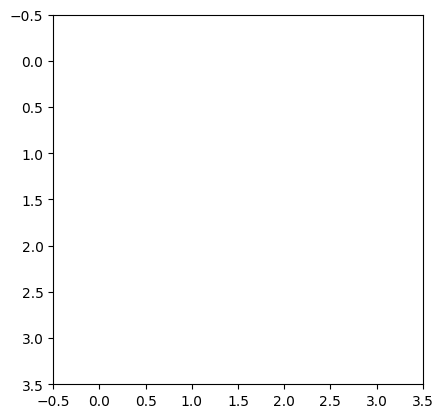

In [84]:
# Run the QAOA algorithm with the bishop puzzle to find the solutions and compare it with brute force ones

# For N = 4 we already have issues converging to anything meaningful, so we will use N = 3
simulator = AerSimulator()
ham, offset = shifted_cost_hamiltonian_bishops(4, 0.1)

optimization_result = QAOA_optimizer(5, ham, offset, simulator)

freq = QAOA_sample_circuit(optimization_result.x, ham, simulator)

freq_plot_solution(freq, 4)

In [85]:
freq

{'0001000001111000': 2,
 '0000000000011000': 3,
 '0100100000000000': 8,
 '0101000000011010': 3,
 '0010100000001100': 1,
 '0010110001000010': 1,
 '1101000000001011': 1,
 '0100000000000000': 10,
 '0101000000111010': 1,
 '0000100000100000': 1,
 '0000000000110000': 3,
 '1100110001000001': 1,
 '0000100000001000': 2,
 '1111011110010001': 1,
 '0101100000001000': 4,
 '1000100110100100': 1,
 '1100010001010001': 1,
 '1000110000010011': 1,
 '1010000001011001': 1,
 '0100001001000010': 2,
 '0001110000101001': 1,
 '1100011000110001': 2,
 '0100000001010010': 4,
 '1000001001001001': 2,
 '0100000010101100': 1,
 '0100000100101100': 1,
 '0010010010000001': 1,
 '0101010111010011': 1,
 '1100111001000001': 1,
 '0001100000000000': 2,
 '0110000100000000': 1,
 '0110010110010010': 1,
 '0110001010100100': 1,
 '1011100000110111': 1,
 '0100100000110110': 1,
 '0000101000000010': 2,
 '0100000000100000': 2,
 '0111100000001100': 1,
 '1010101111100011': 1,
 '0101010100001000': 1,
 '1000000000010001': 8,
 '0001001001101

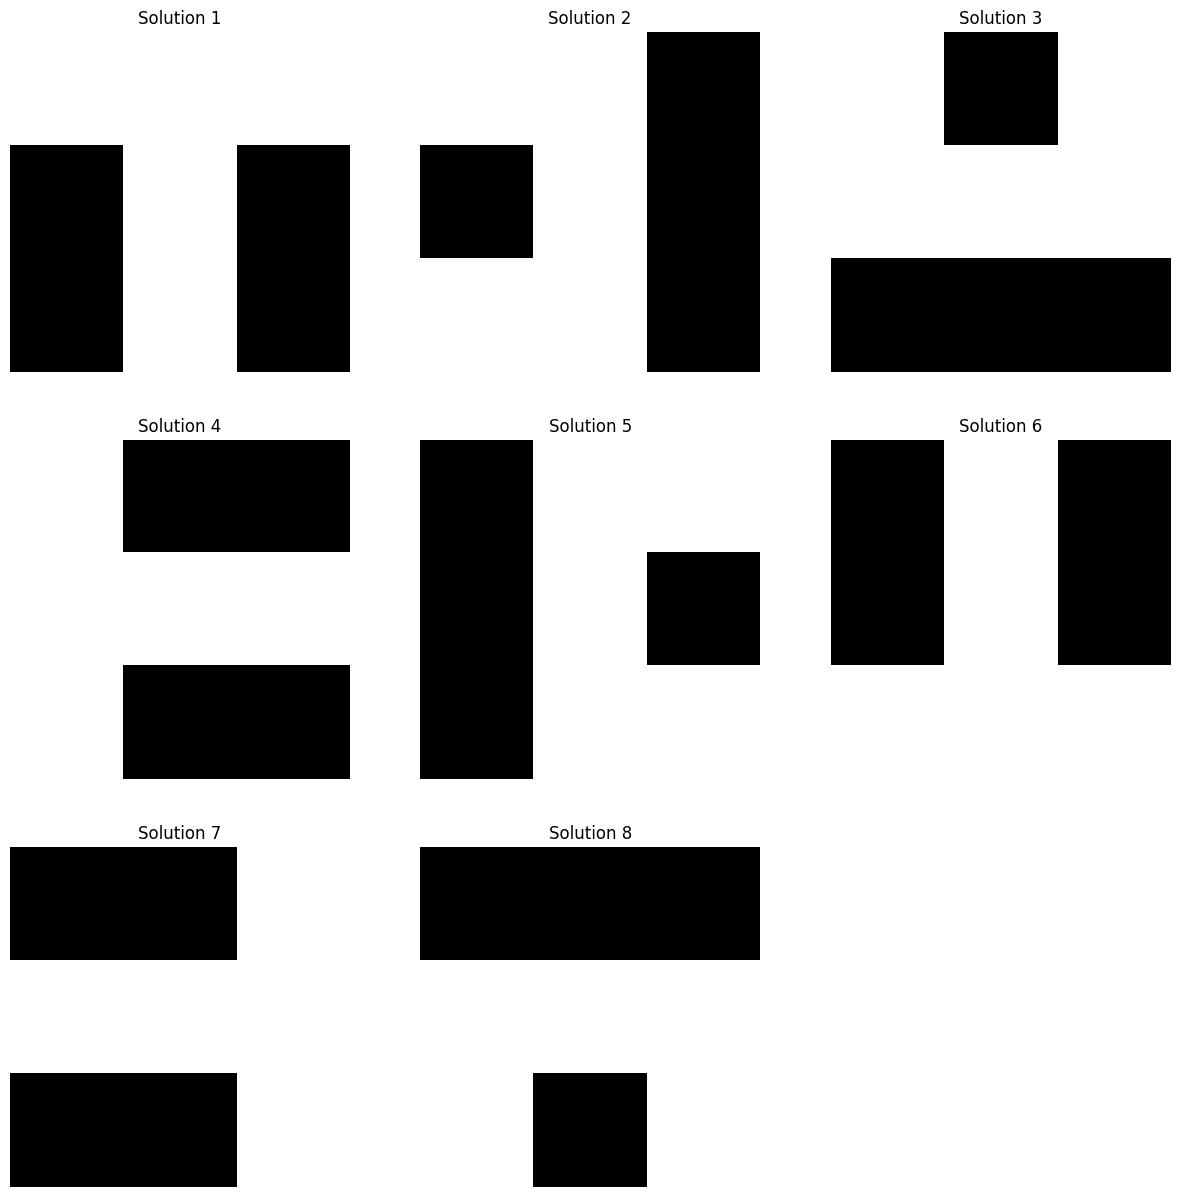

In [86]:
N = 3
valid_matrices = generate_valid_matrices(N)
plot_solutions(valid_matrices, N)

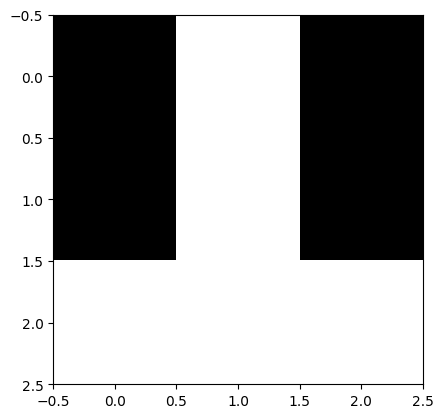

In [91]:
# We can see how we find an optimal solution with the qaoa. If we run the algorithm multiple times we will find
# different solutions, some of them not being optimal but still valid in terms of constraints

simulator = AerSimulator()
ham, offset = shifted_cost_hamiltonian_bishops(3, 0.1)

optimization_result = QAOA_optimizer(3, ham, offset, simulator)

freq = QAOA_sample_circuit(optimization_result.x, ham, simulator)

freq_plot_solution(freq, 3)

# 3- The queens puzzle

Now that we have analyzed both movements of the queens, we can put everything together and find a solution for the queens problem. For that, you only need to combine the two body interactions of the rooks with those of the bishops and voila! The queens cost hamiltonian is done!

Repeat again the previous steps to find the solution for the queens puzzle for 3x3 and 4x4 boards. You can jump some steps if you find them unnecessary, but at the end you should compare the brute force solutions with those obtained by QAOA

## We first find the brute force function for the queens in the NxN chessboard.

In [92]:
# Create the brute force function to find the solutions of the queens puzzle


def check_diagonals(N, vector):
    """Checks the diagonals and returns True if two or more pieces share the same diagonal
    Args:
        N (int): The dimension of the chess board.
        vector (array): vector of (n,1) dimension with the position of the pieces.
    Returns:
        (Boolean): True if two pieces are in the same diagonal
    """

    for i in range(N):
        for j in range(N):
            if abs(i - j) == abs(vector[i] - vector[j]) and i != j:
                return True
    return False


def classical_queens(N):
    """Returns the solutions of the queens puzzle for NxN chess board.

    Args:
        N (int): The dimension of the chess board.

    Returns:
        solutions (np.ndarray): The solutions of the queens puzzle.
    """
    vect = [i for i in range(N)]

    rook_solutions = list(itertools.permutations(vect))
    solutions = []
    for _, sol in enumerate(rook_solutions):
        if check_diagonals(N, sol):
            continue

        solution = np.zeros((N, N))
        for j in range(N):
            solution[j, sol[j]] = 1
        solutions.append(solution)

    return np.array(solutions)

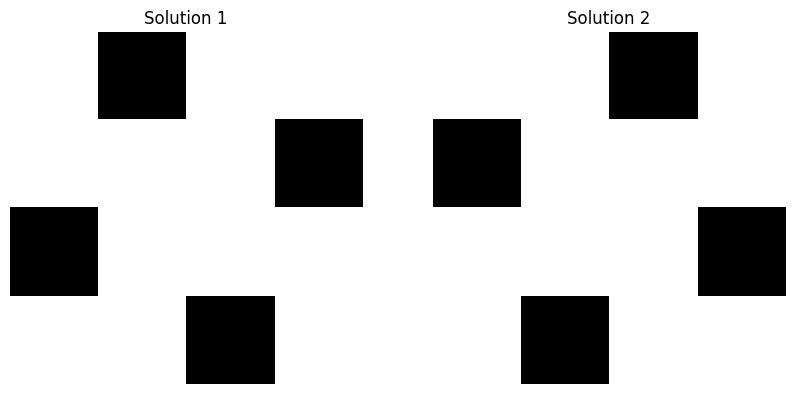

In [93]:
# We check the solutions
N = 4
queen_solutions = classical_queens(N)
plot_solutions(queen_solutions, N)

## We then define the b and Q matrices for the queens and the classical hamiltonian.

In [94]:
# Create the coefficients of the classical cost function for the queens puzzle
def classicalhamiltonian_queen_onebody_coeff(N: int) -> np.ndarray:
    """Returns the NxN matrix of b{k \alpha} weigths.

    Args:
        N (int): The dimension of the chess board.

    Returns:
        b_vector (np.array): The NxN matrix of b{k \alpha} weigths.
    """

    b_vector = -1 * np.ones((N, N))

    return b_vector


def classical_hamiltonian_queens_twobody_coeff(N: int) -> np.ndarray:
    """Returns the NxNxNxN array of Q{k \alpha, l \beta} weigths.

    Args:
        N (int): The dimension of the chess board.

    Returns:
        Qmatrix (np.array): The NxNxNxN array of Q{k \alpha, l \beta} weigths.
    """

    Q_matrix = np.zeros((N, N, N, N))

    for i in range(N):
        Q_matrix[i, :, i, :] = 1.5
        Q_matrix[:, i, :, i] = 1.5

    for k in range(N):
        for alpha in range(N):
            for l in range(N):
                for beta in range(N):
                    if abs(k - l) == abs(alpha - beta) and (k, alpha) != (l, beta):
                        Q_matrix[k, alpha, l, beta] = 1.5

    return Q_matrix


def classical_hamiltonian_queens(N: int, X_string: np.ndarray) -> float:
    """Returns the value of the hamiltonian for a given X_matrix of length NxN.

    Args:
        N (int): The dimension of the chess board.
        X_string (np.array): The NxN matrix of X{k \alpha} values.


    Returns:
        energy (float): The value of the hamiltonian for the given X_string.
    """

    b = classicalhamiltonian_queen_onebody_coeff(N)
    Q = classical_hamiltonian_queens_twobody_coeff(N)

    one_body_energy = np.einsum("ij, ij", X_string, b)

    two_body_energy = 0.0

    for i in range(N):
        for j in range(N):
            X_temp1 = np.zeros((N, N))
            X_temp2 = np.zeros((N, N))

            if X_string[i][j] == 1:
                X_temp1[i, j] = 1
                X_temp2 = X_string - X_temp1

                two_body_energy += 0.5 * np.einsum("kalb, ka, lb", Q, X_temp1, X_temp2)

    return one_body_energy + two_body_energy

### Some examples to test that the output energy is correct

In [48]:
X_string = np.array([[1, 0], [1, 1]])  # Expected 1.5 * 3 - 3 * 1 = 1.5
print(classical_hamiltonian_queens(2, X_string))

X_string = np.array([[1, 0], [0, 1]])  # Expected 1.5 - 2 * 1 = -0.5
print(classical_hamiltonian_queens(2, X_string))

X_string = np.array(
    [[1, 1], [1, 1]]
)  # Expected 1.5 * 6 - 4 * 1 = 5 (The four queens threaten each other in 6 diferent ways, 4 for rook-like behaviour and 2 for bishop-like behaviour)
print(classical_hamiltonian_queens(2, X_string))

1.5
-0.5
5.0


In [96]:
# Create the hamiltonian operator for the queens puzzle, add the tilting


# As with the bishop puzzle, we can reuse the one-body shifted coeffs of the rooks puzzle
def quantum_hamiltonian_queens_twobody_coeff(N) -> tuple[SparsePauliOp, float]:
    """Returns the Sparse Pauli Op representation of the two body term in the N-queens problem.

    Args:
        N (int): The dimension of the chess board.

    Returns:
        sparse_op (SparsePauliOp): The Sparse Pauli Op representation of the two body term.
        offset (float): The offset of the two body term.
    """
    # Your code here
    Q_matrix = classical_hamiltonian_queens_twobody_coeff(N)

    op_strings = []
    op_coeff = []
    offset = 0.0

    for i in range(N):
        for j in range(N):
            for k in range(N):
                for l in range(N):
                    if i > k or j > l:
                        offset += 0.25 * Q_matrix[i, j, k, l]

                        op_strings.append(z_term(i, j, N))
                        op_coeff.append(-0.25 * Q_matrix[i, j, k, l])

                        op_strings.append(z_term(k, l, N))
                        op_coeff.append(-0.25 * Q_matrix[i, j, k, l])

                        op_strings.append(zz_term(i, j, k, l, N))
                        op_coeff.append(0.25 * Q_matrix[i, j, k, l])

    sparse_op = SparsePauliOp(op_strings, op_coeff)
    return sparse_op, offset


def shifted_cost_hamiltonian_queens(N: int, max_tilt: float) -> tuple[SparsePauliOp, float]:
    """Returns the total hamiltonian of the queens puzzle in SparsePauliOp format on a shifted board.

    Args:
        N (int): The size of the chess board.

    Returns:
        hamiltonian (SparsePauliOp): The hamiltonian of the rooks puzzle.
        offset (float): The offset term of the hamiltonian.
    """

    one_term, one_off = shifted_quantum_hamiltonian_rook_onebody_coeff(N, max_tilt)
    two_term, two_off = quantum_hamiltonian_queens_twobody_coeff(N)

    ham = SparsePauliOp.sum([one_term, two_term])
    offset = one_off + two_off

    return ham, offset

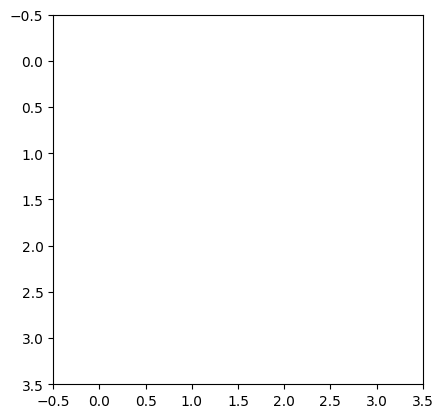

In [98]:
# Run the QAOA algorithm with the queens puzzle to find the solutions and compare it with brute force ones

# As with the bishop puzzle, the qaoa is not able to resolve the full 16 qubits on the N=4 case, so we will use N=3

simulator = AerSimulator()
ham, offset = shifted_cost_hamiltonian_queens(4, 0.1)

optimization_result = QAOA_optimizer(3, ham, offset, simulator)

freq = QAOA_sample_circuit(optimization_result.x, ham, simulator)

freq_plot_solution(freq, 4)

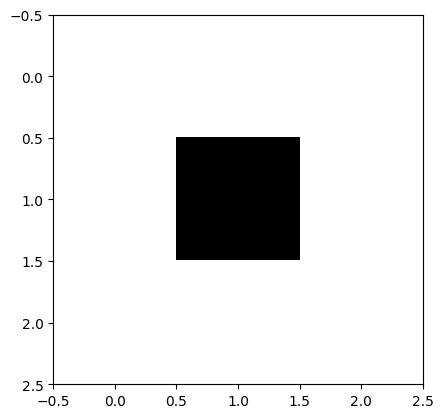

In [103]:
# For N = 3, we still have lots of issues just finding a single queen...
simulator = AerSimulator()
ham, offset = shifted_cost_hamiltonian_queens(3, 0.1)

optimization_result = QAOA_optimizer(3, ham, offset, simulator)

freq = QAOA_sample_circuit(optimization_result.x, ham, simulator)

freq_plot_solution(freq, 3)

> Note: The 3x3 board solution only has 2 queens, while the 4x4 one has 4 queens.

# 4- Going to utility-scale problems

Now that you have solved small instances of the queens puzzle you might think, what's next?? Prepare for the most difficult and exciting part of the challenge!!

The previous sections where only restricted to 3x3 and 4x4 boards because bigger circuits are much expensive to simulate using classical computers and will take a lot of time to do the optimization. Then, you might think, Is this worthy?
Yes, it is. If we run it on a quantum computer!!
Try to run 5x5 and 6x6 boards on it!.

Go again to [IBM web](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm) and try to run a bigger board instance in real quantum hardware.
For that you will need to register on ibm and you will have a maximum of 10 minutes of Q-computations, so be cautious. Plan everything before running it and save every result obtained to present it in the final report.

In [ ]:
# Unfortunately, we have not been able to allocate enough time and resources to run the QAOA algorithm in real hardware.
# However, we do have some takeaways from the results we have obtained in the simulations:
# - The QAOA algorithm is able to find optimal solutions for small problems
# - Apart from the number of qubits, the algorithm also suffers a lot when the used Hamiltonian has lots of
# terms, resulting in very long circuits due to the number of gates needed to implement the exponentiation of the
# Hamiltonian
# - The algorithm is very sensitive to the initial parameters, and the optimization process can get stuck in local often
# - The COBYLA method seems to be more robust than the default scipy minimizer
# - The algorithm is able to find valid solutions for the bishop and queen problems, but the results are not always optimal
# - Having had issues with large problems, running it in real hardware would have pribably added another source of
# errors and issues, so it would have been very difficult to obtain meaningful results for the 16 qubits problems

# EXTRA 1: A farm of horses

The queens and rooks and bishops move in lines, but what about horses?

Explore the possible configurations solutions for the horses puzzle for small boards. Is this problem as easy to converge than the other instances? Which is the biggest difference?

In [ ]:
# Your code here

# EXTRA 2: A parallel story

If you are here, well done, you have already finished all the challenge but if you are still hungry I can provide you more challenging questions. You can of course decline this invitation and enjoy your well deserved rest.

Read the following works about the queens puzzle and compare what they propose with the things that we have done here:

- https://arxiv.org/html/2312.16312v1
- https://quantum-journal.org/papers/q-2019-06-03-149/

Based on those articles, which changes should be done to improve the resolution of the problem? Do you think that this will make a substantial change on your outcomes?

Can you improve the solution of the problem? Maybe propose a new mapping?

# Variational algorithms are not as great as they seem to be at first :)

In [ ]:
# Your code here